In [90]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import math

from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets


## Nozzle Plotter

Input quantities:

- throat radius
- throat curve radius
- expansion half-angle
- ratio of exit area to throat area



In [201]:
class Nozzle:
    def __init__(self,r_t,r_1,alpha,epsilon):
        self.r_t = r_t # radius of throat
        self.r_1 = r_1 # radius of throat curvature
        self.alpha = alpha # expansion half-angle
        self.epsilon = epsilon # throat to exit area ratio
        
        self.recalc() # get derived quantities for initial values
        
    def recalc(self):
        # Establish coordinates for arcs
        self.arcCenter = (0,self.r_t + self.r_1)
        self.arclCenter = (0,-(self.r_t + self.r_1))
        
        # Establish coordinates for wall lines
        #n_x and n_y are coordinates for the entry point
        self.n_x = self.r_1*math.sin(math.radians(self.alpha))
        self.n_y = self.r_t+(self.r_1*(1-math.cos(math.radians(self.alpha))))
        
        #e_x and e_y are coordinates for the exit point
        self.r_e = math.sqrt(self.epsilon)*self.r_t
        self.e_y = self.r_e
        self.e_x = self.n_x + (self.r_e-self.n_y)/math.tan(math.radians(self.alpha))
        
    def newParams(self,r_t,r_1,alpha,epsilon):
        self.r_t = r_t
        self.r_1 = r_1
        self.alpha = alpha # expansion half-angle
        self.epsilon = epsilon # throat to exit area ratio
        
        self.recalc() # get derived quantities for initial values
        self.draw() # draw new figure
        
    def area(self,x): # return area of nozzle at position x
        xmin = -self.r_1  # minimum x
        x_trans = self.n_x # transition x
        x_out = self.e_x # x at exit
        retval = 0
        
        if(x<xmin):
            #print("x below range")
            z=0
        elif(x>=xmin and x<x_trans):
            #x is within inlet circle
            retval = math.pi*((self.r_t+self.r_1)-(math.sqrt((self.r_1**2)-(x**2))))**2
        elif(x>x_trans and x<=x_out):
            # x is in cone area
            m = ((self.e_y-self.n_y)/(self.e_x-self.n_x))
            b = (-m)*(self.n_x)+self.n_y
            
            retval = math.pi*((m*x+b)**2) #d'oh
        else:
            #print("x is above range")
            z=0
        return retval
    
    def xvals(self): # returns a list that evenly divides the x-coordinates into intervals
        
        
    
    def draw(self):
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)
        
        axes = plt.gca()
        axes.set_xlim([-1,9])
        axes.set_ylim([-3,3])
        
        figh = 2*self.r_1
        figw = 2*self.r_1
        arc = mpatches.Arc(xy=self.arcCenter,width=figw,height=figh,theta1=180, theta2=270+self.alpha)
        arcLow = mpatches.Arc(xy=self.arclCenter,width=figw,height=figh,theta1=90-self.alpha, theta2=180)
        
        ax.add_patch(arc)
        ax.add_patch(arcLow)
        
        ax.plot([self.n_x,self.e_x],[self.n_y,self.e_y])
        ax.plot([self.n_x,self.e_x],[-self.n_y,-self.e_y])
        
        plt.show()

In [221]:
schnozz = Nozzle(0.5,1,15,5)

w_tr = widgets.FloatSlider(min=0.1,
                           max=1, 
                           step=0.05,
                           value=0.5,
                           continuous_update=False,
                          description = 'Throat Radius') # throat radius widget
w_tc = widgets.FloatSlider(min=0.1, 
                           max=1, 
                           step =0.05,
                           value=0.7,
                           continuous_update=False,
                          description = 'Curve Radius') # throat curve radius widget
w_a = widgets.FloatSlider(min=0.1,
                          max=30, 
                          step=0.1,
                           continuous_update=False,
                         description='Wall Angle') # wall angle widget
w_e = widgets.FloatSlider(min=1.1, 
                          max=10, 
                          step=0.1,
                           continuous_update=False,
                         description='Area Ratio') # area ratio widget
ui = widgets.VBox([w_tr,w_tc,w_a,w_e])

out = widgets.interactive_output(schnozz.newParams, {'r_t':w_tr,'r_1':w_tc,'alpha':w_a,'epsilon':w_e})

display(ui,out)

Output()

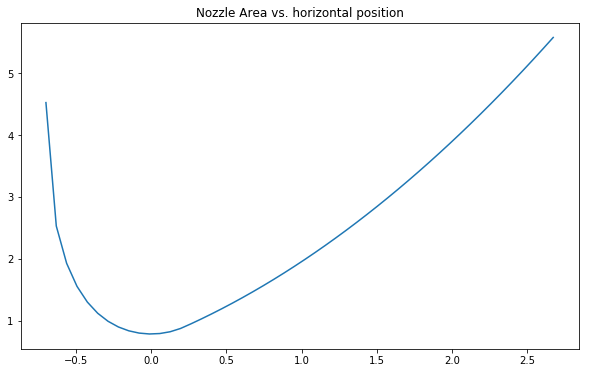

In [250]:
#
# Plotting out area vs. horizontal position
#

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
#print(xrange)

yrange = []
for x in xrange:
    yrange.append(schnozz.area(x))

ax.plot(xrange,yrange)
plt.title("Nozzle Area vs. horizontal position")
plt.show()




# Derived Quantities

Quantities of interest are massflow, pressure, temperature, density, and velocity.


## Continuity relation
$\dot m = \rho A(x)\bar V$

- massflow is equal to change in mass over time, and is constant

## Constants

In [280]:
A_0 = schnozz.area(0)

# These are for our exhaust gas at the throat of the nozzle.
p_0 = 101325
R_spec = 287.058
T_0 = 2253.15

C_v = 0.929 # constant volume specific heat capacity of air at 1500K
C_p = 1.216 # constant pressure specific heat of air at 1500k
k = 1.4 #ratio of specific heats for air (approximate)
molmass = 0.0289 # molar mass of air in kg/mol

massflow = 2 # this is in kg /s

## Entropy

## Density of Exhaust Gas

$ \rho = \frac{p}{R_{spec}}{T} $

For our conditions

$p = 101325$ Assuming one atmosphere of pressure

$R_{spec} = 287.058 \frac{J}{Kg \cdot K} $  This is for air - update later to exhaust gas composition

$T = 1980^\circ C = 2253.15 K $

## Alternate Density
$ \rho (x) = \frac{\dot m}{A(x)V(x)} $


In [281]:
rho = lambda x: p_0/(R_spec*T_0)

print(rho(0))

0.1566595420040594


## Exhaust Velocity

For small values of velocity V relative to c, velocity can be approximated using the relation for incompressible flow:


$ \bar VA = constant $

Given the area at the throat and the velocity at the throat $A_0$ and $\bar V_0$,

$ \bar V(x) = A(x)\frac{\bar V_0}{A_0} $

Also

$ \dot m = \rho A(x)V(x) $

$ \bar V(x) = \frac{\dot m }{\rho A(x)} $


In [241]:
V = lambda x: massflow/(schnozz.area(x)*rho(x))

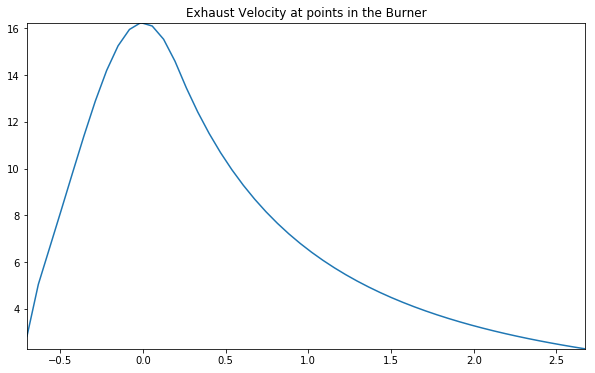

In [251]:
# Define the points to be plotted
velocity = []

xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
for x in xrange:
    velocity.append(V(x))
    
# Set up the plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# Define limits for graph axes
axes = plt.gca()
axes.set_ylim([min(velocity),max(velocity)])
axes.set_xlim([min(xrange),max(xrange)])
    
# Plot the chart
ax.plot(xrange,velocity)
plt.title("Exhaust Velocity at points in the Burner")
plt.show()

## Specific Volume

Specific volume is the reciprocal of density, or:

$ \bar v = \frac{V}{m} = \rho^{-1} $

$ \bar v(x) = lim_{\Delta x \to 0} \frac{A(x)\Delta x}{\dot m} $

$ \bar v(x) = lim_{\Delta x \to 0} \frac{A(x)\Delta x}{dm / dt} $

$ \bar V = \frac{dx}{dt} $ 

$ dt = dx/\bar V $

$ \bar v(x) = lim_{\Delta x \to 0} \frac{A(x) \Delta x}{dm \cdot \bar V / dx} $

$ \bar v(x) = \frac{A(x)}{dm \cdot \bar v} $

In [245]:
v_spec = lambda x: 1/rho(x)

## Specific Enthalpy of exhaust gases

Calculating Enthalpy.

$ h = u + pv $

So finding u, or specific internal energy is first:

$ u= \frac{nC_vT}{m} $

$ \frac{n}{m} $ is the reciprocal of molar mass


https://webbook.nist.gov/cgi/cbook.cgi?Name=nitrogen&Units=SI

In [256]:
u_0 = (1/molmass)*C_v*T_0

In [258]:
h_0 = u_0 + p_0*v_spec(0)

Steady state adiabatic first law equation:

- Height does not change
- heat and work transfer are zero (adiabatic)
- massflow is constant
- no change in total energy of the system

$ h_i + \frac{\bar V_i^2}{2} = h_e +  \frac{\bar V_e^2}{2} $

$ dh + \frac{d\bar V^2}{2} = 0 $

$ (h_x - h_0) + \frac{1}{2}(\bar V_x-\bar V_0)^2 = 0 $

$ h(x) = h(0) -\frac{1}{2}(\bar V(x) - \bar V(0))^2 $

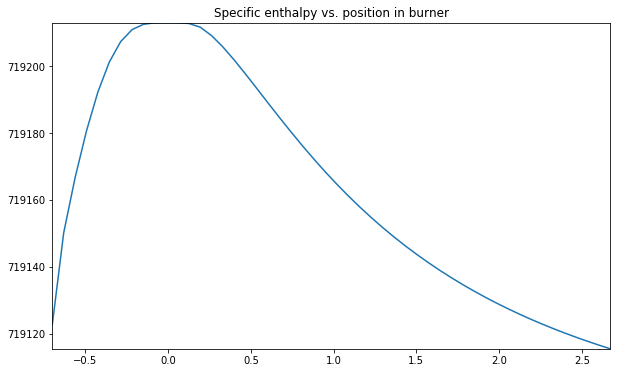

In [267]:
# equation for specific enthalpy
h = lambda x: h_0 -0.5*(V(x)-V(0))**2

# Define the points to be plotted
senthalpy = []

xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
for x in xrange:
    senthalpy.append(h(x))
    
# Set up the plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# Define limits for graph axes
axes = plt.gca()
axes.set_ylim([min(senthalpy),max(senthalpy)])
axes.set_xlim([min(xrange),max(xrange)])
    
# Plot the chart
ax.plot(xrange,senthalpy)
plt.title("Specific enthalpy vs. position in burner")
plt.show()

## Temperature of exhaust gases
$ h_2-h_1 = c_p(T_2-T_1) $

$ \frac{h_2-h_1}{c_p}+T_1 = T_2 $

$ T(x) = \frac{h(x)-h(0)}{c_p}+T(0) $

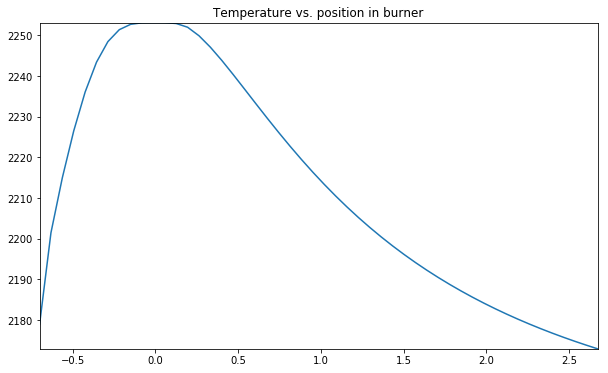

In [282]:
T = lambda x: (h(x)-h(0))/(C_p) + T_0

# Define the points to be plotted
temps = []

xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
for x in xrange:
    temps.append(T(x))
    
# Set up the plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# Define limits for graph axes
axes = plt.gca()
axes.set_ylim([min(temps),max(temps)])
axes.set_xlim([min(xrange),max(xrange)])
    
# Plot the chart
ax.plot(xrange,temps)
plt.title("Temperature vs. position in burner")
plt.show()

$\rho = \frac{P}{RT} $

$ P = \rho R T $

In [278]:
P = lambda x: rho(x) * R_spec * T(x)

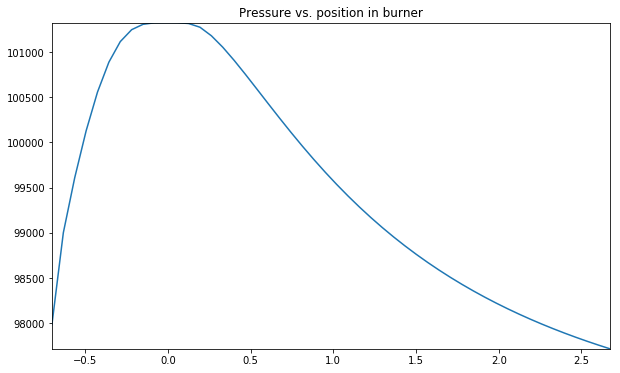

In [283]:
# Define the points to be plotted
pressures = []

xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
for x in xrange:
    pressures.append(P(x))
    
# Set up the plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# Define limits for graph axes
axes = plt.gca()
axes.set_ylim([min(pressures),max(pressures)])
axes.set_xlim([min(xrange),max(xrange)])
    
# Plot the chart
ax.plot(xrange,pressures)
plt.title("Pressure vs. position in burner")
plt.show()

Reference material:
http://seitzman.gatech.edu/classes/ae6450/nozzle_geometries.pdf